In [1]:
from pyspark.sql.functions import explode
from pyspark.sql.functions import split

from pyspark.context import SparkContext
from pyspark.conf import SparkConf
from pyspark.sql.session import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.window import Window

spark = SparkSession.builder \
    .appName("MyApp") \
    .config("spark.jars.packages", 'org.apache.spark:spark-sql-kafka-0-10_2.12:3.0.0') \
    .config("spark.sql.repl.eagerEval.enabled", True) \
    .getOrCreate()


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
:: loading settings :: url = jar:file:/usr/local/lib/python3.9/dist-packages/pyspark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml
org.apache.spark#spark-sql-kafka-0-10_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-c1288965-851a-4452-92b9-cc8b835e6596;1.0
	confs: [default]
	found org.apache.spark#spark-sql-kafka-0-10_2.12;3.0.0 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.12;3.0.0 in central
	found org.apache.kafka#kafka-clients;2.4.1 in central
	found com.github.luben#zstd-jni;1.4.4-3 in central
	found org.lz4#lz4-java;1.7.1 in central
	found org.xerial.snappy#snappy-java;1.1.7.5 in central
	found org.slf4j#slf4j-api;1.7.30 in central
	found org.spark-project.spark#unused;1.0.0 in central
	found org.apache.commons#commons-pool2;2.6.2 in central
:: resolution report :: resolve 309ms :: artifacts dl 3m

Be sure to start the stream on Kafka!

In [2]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, BooleanType, TimestampType, DateType

schema = StructType(
      [
        StructField("name", StringType(), False),
        StructField("price", DoubleType(), False),
        StructField("timestamp", TimestampType(), False),
      ]
    )


In [3]:
kafka_server = "kafka1:9092"   
from pyspark.sql.functions import from_json

lines = (spark.readStream                        # Get the DataStreamReader
  .format("kafka")                                 # Specify the source format as "kafka"
  .option("kafka.bootstrap.servers", kafka_server) # Configure the Kafka server name and port
  .option("subscribe", "stock")                       # Subscribe to the "en" Kafka topic 
  .option("startingOffsets", "earliest")           # The start point when a query is started
  .option("maxOffsetsPerTrigger", 100)             # Rate limit on max offsets per trigger interval
  .load()
  .select(from_json(col("value").cast("string"), schema).alias("parsed_value"))
# Load the DataFrame
)
df = lines.select("parsed_value.*")


## The assignment starts here

You can create a

## Select the N most valuable stocks in a window

In [12]:
stock_portfolio = spark.createDataFrame([
    ('ISRG', 10.0),
    ('BBT', 15.0),
    ('FITB', 15.0),
    ('ZION', 5.0),
    ('CL', 15.0),
    ('KR', 90.0),
    ('WEC', 80.0),
    ('VRTX', 40.0),
    ('PNW', 15.0),
    ('DTE', 16.0)], ["name", "amount_of_stocks_owned"])

stock_portfolio.show()

# Join hai DataFrame dựa trên tên cổ phiếu
portfolio_with_prices = stock_portfolio.join(df, "name", "inner")

# Tính toán giá trị tài sản của bạn
portfolio_with_prices = portfolio_with_prices.withColumn("asset_value", col("amount_of_stocks_owned") * col("price"))

# Tính tổng giá trị tài sản
total_asset_value = portfolio_with_prices.selectExpr("sum(asset_value) as total_asset_value")

query_5 = (total_asset_value.writeStream
        .outputMode("update")
        .format("memory")
        .queryName("AssetValue1").start())


+----+----------------------+
|name|amount_of_stocks_owned|
+----+----------------------+
|ISRG|                  10.0|
| BBT|                  15.0|
|FITB|                  15.0|
|ZION|                   5.0|
|  CL|                  15.0|
|  KR|                  90.0|
| WEC|                  80.0|
|VRTX|                  40.0|
| PNW|                  15.0|
| DTE|                  16.0|
+----+----------------------+



23/11/06 11:49:28 WARN StreamingQueryManager: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-52114116-37b2-452e-a70c-3c4ba35ee546. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.


Text(0, 0.5, 'Total Asset Value')

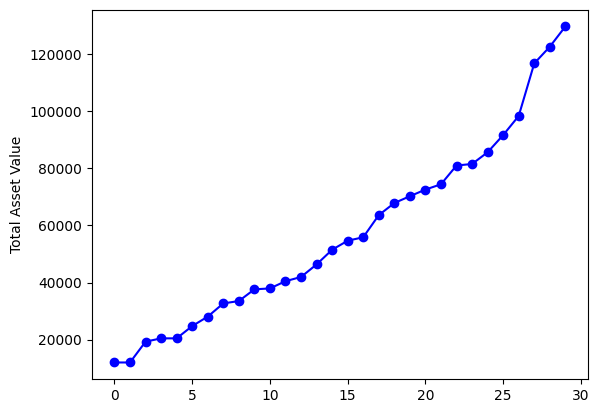

In [14]:
from matplotlib import pyplot as plt
import mplcursors

test = spark.sql("SELECT * FROM AssetValue1")
test = test.toPandas()
# Vẽ biểu đồ đường
plt.plot(test.index, test["total_asset_value"], marker='o', linestyle='-', color='b')
plt.ylabel("Total Asset Value")

In [ ]:
query_5.awaitTermination()